<a href="https://colab.research.google.com/github/FatimaEzzedinee/ML-bachelor-course-labs-sp24/blob/main/04_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning SP 2024/2025

- Prof. Cesare Alippi
- Mikhail Andronov ([`mikhail.andronov@usi.ch`](mailto:mikhail.andronov@usi.ch))<br>
- Valentina Moretti ([`valentina.moretti@usi.ch`](mailto:valentina.moretti@usi.ch))<br>
- Samuele Pasini ([`samuele.pasini@usi.ch`](mailto:samuele.pasini@usi.ch))

---
# Lab 04: Deep Learning

___

In this lab we will see:

0. Theoretical recap of neural networks;
1. How to implement, train and evaluate a Fully Connected Neural Network (FCNN) for **regression** with `PyTorch`;
2. How to implement, train and evaluate a Convolutional Neural Network (CNN) for **classification** with `PyTorch`.

---


# 0. Theoretical Recap of Neural Networks

The core component of neural networks is the neuron, which is composed of a perceptron and an activation function:

$$
f(x; \boldsymbol \theta) =  h( x^T \boldsymbol \theta).
$$

The main idea behind neural networks is to compose neurons in two different ways:

1. by taking many neurons __in parallel__;
2. by composing many subsequent __layers__ of neurons;

The result is a network of neurons that take data as input, and compute sequential transformations until the desired result is produced as output.

---

We can write the output of the hidden layer as:

$$
\begin{bmatrix}
h_0 \\
h_1 \\
h_2 \\
\vdots\\
h_l
\end{bmatrix}
=
h\left(
\begin{bmatrix}
w_{00} & w_{01} & w_{02} & \cdots & w_{0m} \\
w_{10} & w_{11} & w_{12} & \cdots & w_{1m} \\
w_{20} & w_{21} & w_{22} & \cdots & w_{2m} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
w_{l0} & w_{l1} & w_{l2} & \cdots & w_{lm} \\
\end{bmatrix}
\begin{bmatrix}
x_0 \\
x_1 \\
x_2 \\
\vdots\\
x_m
\end{bmatrix}
+
\begin{bmatrix}
b_0 \\
b_1 \\
b_2 \\
\vdots\\
b_l
\end{bmatrix}
\right)
$$

In short, we write the output of a __layer__ of neurons as:
$$
H = h(Wx + b_w)
$$

_NB: without the activation function a layer is a simple affine trasformation._

We can compute the output of the network doing the same calculation for the  "Output" neurons, with the difference that their input is not $X$, as for the hidden neurons, but it is the output $H$ of the last hidden layer. The output layer can be written as:

$$
Y = \sigma(VH + b_v)
$$

(note that $V$ is a different matrix of parameters).

Finally, stacking the two layers simply means __composing__ them together, so that the whole neural network can be written as:

$$
\hat y = f(x;\boldsymbol \theta = \{W, b_w, V, b_v\}) = \sigma\left(V h(Wx + b_w)  + b_v\right)
$$

---
Neural networks are trained with __stochastic gradient descent__ (SGD). The key idea behind SGD is to update all the parameters of the network at the same time, based on how each parameter contributed to the __loss__ function $L( \boldsymbol \theta)$.

The generalized update rule reads:

$$
{\boldsymbol \theta}^{i+1} = {\boldsymbol \theta}^{i} - \varepsilon \frac{\partial L({\boldsymbol \theta})}{\partial {\boldsymbol \theta}}\bigg\vert_{{\boldsymbol \theta} = {\boldsymbol \theta}^i}
$$

where $\varepsilon$ is again called __learning rate__.

At each iteration:

1. We take a **batch** ($x_n$, $y_n$) of samples from the dataset;
2. We compute the **output** $\hat{y_n}$ of the network for each sample in the batch;
3. We compute an empirical estimate of the **loss** $L$ on the batch;
4. We compute the **gradient** of the loss with respect to the parameters of the network (**backpropagation**);
5. We update the parameters of the network with the **optimizer** rule (e.g., SGD, Adam, RMSprop, etc.).

Look at Tutorial 1 to refresh your memory on Gradient Descent and Backpropagation. There we implemented the gradients of the loss function with respect to the parameters of the network by hand. In this lab we will use `PyTorch` to do this for us.

---
When training neural networks for **regression**, we often take the loss to be the __mean squared error function__:

$$
L({\boldsymbol \theta}) =  \frac{1}{N} \sum_{n=1}^N \left(y_n - \hat y_n\right)^2
$$

or the __mean absolute error function__:

$$
L({\boldsymbol \theta}) =  \frac{1}{N} \sum_{n=1}^N \left|y_n - \hat y_n\right|
$$


When training neural networks for **classification**, we often take the loss to be the __cross-entropy error function__:

$$
L({\boldsymbol \theta}) =  -\frac{1}{N} \sum_{n=1}^N \sum_{c=1}^C y_{nc} \log(\hat y_{nc})
$$

where $C$ is the number of classes, and $y_{nc}$ is the true label of the $n$-th sample for the $c$-th class.

---

# A) Fully Connected Neural Network (FCNN) for Regression

To build our neural network we will use [PyTorch](https://pytorch.org/), one of the most popular deep learning libraries for Python (others being [JAX](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html) and [TensorFlow](https://www.tensorflow.org/)).

PyTorch provides a huge number of functions, like Numpy, that can be used to manipulate arrays, but offers a great advantages w.r.t. Numpy:  the library implements __automatic differentiation__, meaning that the most analytically complex step of training, the computation of the gradient, is handled for you.

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c6/PyTorch_logo_black.svg/2560px-PyTorch_logo_black.svg.png)

## A.1) Collect and prepare the data

Let's start with a toy regression problem.

To use PyTorch, you'll need to import the necessary libraries. The standard are:
- `torch.nn` contains various neural network modules
- `torch.optim` provides optimization algorithms.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import os
import numpy as np
# # We can seeif a GPU is available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)


# # For Mac users you can try
device = torch.device('mps' if torch.backends.mps.is_available() else "cpu") 
print(device)

mps


/var/folders/4j/ll5k3mtd2430bt6vm4x2dt7c0000gn/T/ipykernel_47609/2653838345.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.tanh(5*x**5 + np.sinc(2*x) - 0.2*np.sin((x-0.5)*5)/(x-0.5) - np.exp(-(x**2)/0.02)) # Very complex function


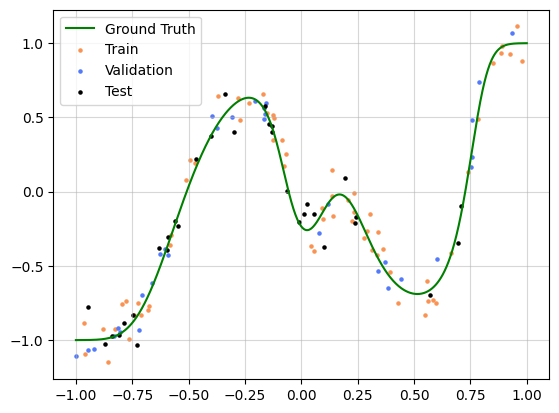

In [2]:
# Create dataset
import numpy as np
import matplotlib.pyplot as plt

Ct = '#fa9352'
Cv = '#527afa'

def ground_truth(x):
    return np.tanh(5*x**5 + np.sinc(2*x) - 0.2*np.sin((x-0.5)*5)/(x-0.5) - np.exp(-(x**2)/0.02)) # Very complex function

def generate_data(n_samples=512, seed=42):
    np.random.seed(seed)
    x = np.random.rand(n_samples) * 2 - 1
    # x = np.linspace(-1, 1, n_samples)
    y = ground_truth(x) + np.random.randn(n_samples) * 0.1
    return torch.tensor(x, dtype=torch.float).reshape(-1, 1), torch.tensor(y, dtype=torch.float).reshape(-1, 1)

ground_truth_x = torch.linspace(-1, 1, 1000).reshape(-1, 1)
ground_truth_y = ground_truth(ground_truth_x)
plt.plot(ground_truth_x, ground_truth_y, label='Ground Truth', color='g')

x_train, y_train = generate_data(n_samples=64, seed=0)
x_val, y_val = generate_data(n_samples=32, seed=1)
x_test, y_test = generate_data(n_samples=32, seed=2)

plt.scatter(x_train, y_train, s=5, label='Train', color=Ct)
plt.scatter(x_val, y_val, s=5, label='Validation', color=Cv)
plt.scatter(x_test, y_test, s=5, label='Test', color='k')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

## A.2) Define the network

To build a neural network in PyTorch, you need to define a class that inherits from `torch.nn.Module`. This class should have two main methods:
- `__init__` method, where you define the layers of the network;
- `forward` method, where you define the forward pass of the network.

In [3]:
class FCNN(nn.Module):
    def __init__(self):     # Here we define the structure of the network
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(1, 2)
        self.fc2 = nn.Linear(2, 1)
        self.activation = nn.Sigmoid()

    def forward(self, x):   # Here we define the forward pass
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

model = FCNN().to(device) # Create the model and move to device (GPU or CPU)

Voilà! You have a neural network.

How do you think it performs on the data?

Well? Why / Why not?

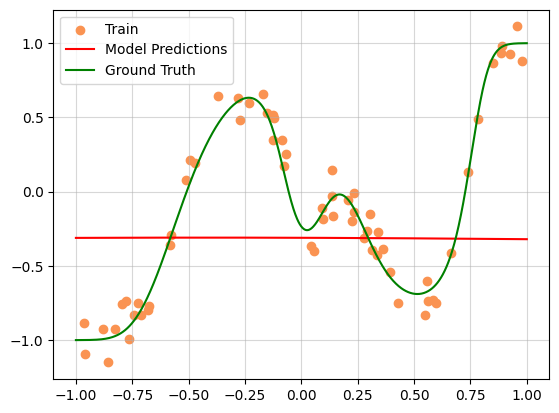

In [4]:
y_pred = model(ground_truth_x.to(device)) # Forward pass

plt.scatter(x_train, y_train, label='Train', color=Ct)
plt.plot(ground_truth_x, y_pred.detach().cpu(), label='Model Predictions', color='r')
plt.plot(ground_truth_x, ground_truth_y, label='Ground Truth', color='g')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

## A.3) Train the network

To train the network, you need to:
- Define an optimizer (e.g., `torch.optim.SGD`, `torch.optim.Adam`, etc.);
- Define a loss function (e.g., `torch.nn.MSELoss`, `torch.nn.L1Loss`, etc.);
- Loop over the dataset, and for each batch:
    - Compute the output of the network;
    - Compute the loss;
    - Compute the gradients of the loss with respect to the parameters of the network;
    - Update the parameters of the network with the optimizer.

    
We will use the `torch.optim.Adam` optimizer and the `torch.nn.MSELoss` loss function.

Epoch: 0 - Loss: 0.7347796559333801
Epoch: 10 - Loss: 0.5165505409240723
Epoch: 20 - Loss: 0.39995694160461426
Epoch: 30 - Loss: 0.3559587299823761
Epoch: 40 - Loss: 0.3463532328605652
Epoch: 50 - Loss: 0.344258189201355
Epoch: 60 - Loss: 0.3411920666694641
Epoch: 70 - Loss: 0.33773791790008545
Epoch: 80 - Loss: 0.3346136808395386
Epoch: 90 - Loss: 0.33148086071014404


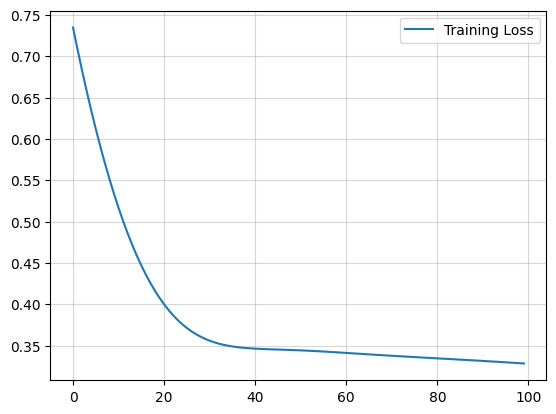

In [5]:
# Reinitalize the model
model = FCNN().to(device)
model.train() # Set the model to training mode
# Training
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

training_losses = []

n_epochs = 100
# Training loop
for epoch in range(n_epochs):
    optimizer.zero_grad()               # Zero the gradients

    y_pred = model(x_train.to(device))             # Forward pass

    loss = criterion(y_pred, y_train.to(device))   # Compute the loss
    loss.backward()                     # Compute the gradients
    optimizer.step()                    # Update the weights

    if epoch % 10 == 0:
        print(f'Epoch: {epoch} - Loss: {loss.item()}')
    training_losses.append(loss.item()) # Save the loss for plotting

plt.plot(training_losses, label='Training Loss')

plt.legend()
plt.grid(alpha=0.5)
plt.show()

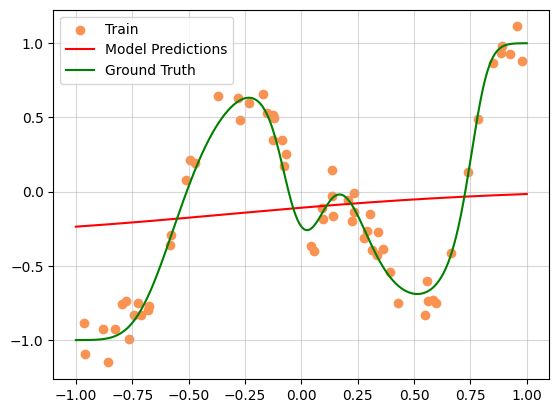

In [6]:
# Plot the model predictions
model.eval() # Set the model to evaluation mode
with torch.no_grad(): # No need to compute gradients
    y_pred = model(ground_truth_x.to(device)) # Forward pass
plt.scatter(x_train, y_train, label='Train', color=Ct)
plt.plot(ground_truth_x, y_pred.detach().cpu(), label='Model Predictions', color='r')
plt.plot(ground_truth_x, ground_truth_y, label='Ground Truth', color='g')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

Is it better? Now try to:
1. Change `n_epochs`
2. Change `lr`

### Exercise: Bigger model

Now, let's try to build a bigger model, in order to do so modify the `__init__` method of the `FCNN` class to allow for a different number of neurons in the hidden layer.




In [7]:
class FCNN(nn.Module):
    def __init__(self, hidden_dim):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.activation = nn.Sigmoid()

    def forward(self, x):   # Here we define the forward pass
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

### Train loop

As we are building a bigger model, **can we use the same training loop or we should monitor something else?** Why/Why not?

In [8]:
def train(model, criterion, optimizer, x_train, y_train, x_val, y_val, n_epochs, eval_freq, device):
    training_losses = []
    validation_losses = []

    for epoch in range(n_epochs):
        model.train()                       # Set the model to training mode, this is important for some layers (e.g. dropout)
        optimizer.zero_grad()               # Zero the gradients

        y_pred = model(x_train.to(device))             # Forward pass

        loss = criterion(y_pred, y_train.to(device))   # Compute the loss
        loss.backward()                     # Compute the gradients
        optimizer.step()                    # Update the weights

        training_losses.append(loss.item()) # Save the loss for plotting

        # Validation
        model.eval()                        # Set the model to evaluation mode
        if epoch % eval_freq == 0:
            with torch.no_grad():            # No need to compute the gradients
                y_val_pred = model(x_val.to(device))
                val_loss = criterion(y_val_pred, y_val.to(device))
                validation_losses.append(val_loss.item())

            print(f'Epoch {epoch}, Train Loss {loss.item()}')
            print(f'Validation Loss {val_loss.item()}')
            print('')
    return training_losses, validation_losses

Epoch 0, Train Loss 0.4034670889377594
Validation Loss 0.4684790074825287

Epoch 100, Train Loss 0.2788100242614746
Validation Loss 0.2841881215572357

Epoch 200, Train Loss 0.2766474187374115
Validation Loss 0.27877163887023926

Epoch 300, Train Loss 0.2685863971710205
Validation Loss 0.2596871256828308

Epoch 400, Train Loss 0.24160104990005493
Validation Loss 0.20730412006378174

Epoch 500, Train Loss 0.22362393140792847
Validation Loss 0.18216288089752197

Epoch 600, Train Loss 0.06792881339788437
Validation Loss 0.037240561097860336

Epoch 700, Train Loss 0.03626921772956848
Validation Loss 0.023159872740507126

Epoch 800, Train Loss 0.028845185413956642
Validation Loss 0.021020375192165375

Epoch 900, Train Loss 0.02469611167907715
Validation Loss 0.019373375922441483



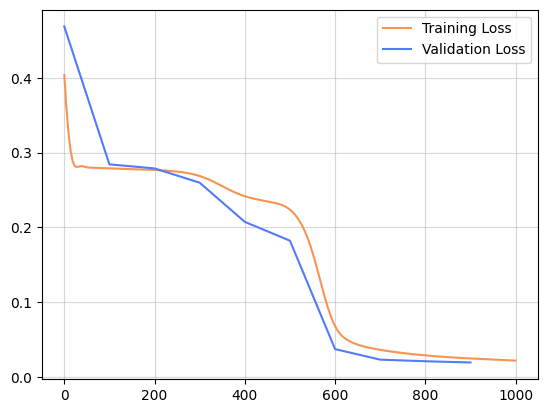

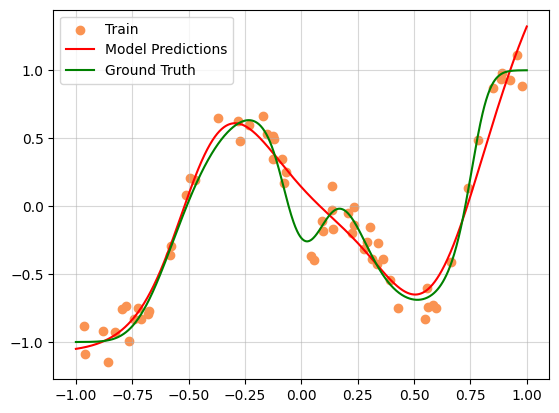

In [9]:
# Reinitalize the model
model = FCNN(hidden_dim=32).to(device) # Create the model and move to device (GPU or CPU)

# Training
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
eval_freq = 100
n_epochs = 1000
# Let's train the model
training_losses, validation_losses = train(model, criterion, optimizer, x_train, y_train, x_val, y_val, n_epochs, eval_freq, device)

plt.plot(training_losses, label='Training Loss', color=Ct)
plt.plot(np.arange(0, n_epochs, 100), validation_losses, label='Validation Loss', color=Cv)

plt.legend()
plt.grid(alpha=0.5)
plt.show()

# Plot the model predictions
y_pred = model(ground_truth_x.to(device)) # Forward pass
plt.scatter(x_train, y_train, label='Train', color=Ct)
plt.plot(ground_truth_x, y_pred.detach().cpu(), label='Model Predictions', color='r')
plt.plot(ground_truth_x, ground_truth_y, label='Ground Truth', color='g')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

With almost zero effort or knowledge we achieved pretty good results! N.B. this is not always the case, Deep Learning is not magic, but it is a powerful tool.

### Exercise 1 - Home: Activation function
Change the activation function to ReLU and see what happens.

### Execise 2 - Home: Arbitrarly big model with `nn.ModuleList`
`nn.ModuleList` is a container for modules that can be accessed by index (similar to Python lists).

 It's useful when you need to create and manage a variable number of modules, or when the forward pass through the network involves more complex, non-sequential operations.

 Create a network using `nn.ModuleList` to add arbitrary number of layers with arbitrary dimension for each layer

Now experiment with it to gain confidence with PyTorch and neural networks.

# B) Convolutional Neural Network (CNN) for Classification

In this part we will explore how to build a Convolutional Neural Network (CNN) for a classification task.

We will also explore three important concepts in Deep Learning:
- `torch.utils.data.Dataset` **and** `torch.utils.data.DataLoader`: classes to load and preprocess the data in torch;
- **Unbalanced Datasets**: a common problem in classification tasks, where the number of samples in each class is not equal.
- **Data Augmentation**: a technique to artificially increase the size of the training set by applying transformations to the input data;
- **Early Stopping**: a technique to prevent overfitting by stopping the training when the validation loss increases for a certain number of epochs.


We will use the `torchvision` library to load and preprocess the data.

But first, a brief recap on CNNs.

![alt text](https://upload.wikimedia.org/wikipedia/commons/6/63/Typical_cnn.png)


CNNs were first introduced by Kunihiko Fukushima in 1980, and were later popularized by Y. LeCun, when he successfully applied backpropagation to train CNNs on MNIST.

In CNNs, we use our **prior knowledge** about the problem (i.e., the data are translational invariant), imposing that neurons **share** some weights (i.e., the convolutional kernels).


# B.1) Load and preprocess the data

We will use the CIFAR-10 dataset, which consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.

### B.1.1) Downoad the data

In [11]:
# Download the dataset
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np

# Define the transformations to apply to the images and download the dataset
transformations = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].
cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transformations)
cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transformations)
# Split in test and validation
cifar10_val, cifar10_test = torch.utils.data.random_split(cifar10_test, [5000, 5000])
class_label_map = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

100.0%


In [12]:
# Plot 9 random images from the dataset
def plot_9_random_images(dataset, with_predictions=False, model=None):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))                            # Create a figure and a grid of subplots
    for i in range(3):
        for j in range(3):
            random_indeces = np.random.randint(len(dataset))            # Get 9 random indeces
            x, y = dataset[random_indeces]
            axes[i, j].imshow(x.permute(1, 2, 0).numpy() * 0.5 + 0.5)   # Rearrange the dimensions of the tensor from (C, H, W) to (H, W, C),
                                                                        # which is the expected format for Matplotlib's imshow function.
                                                                        # The * 0.5 + 0.5 operation is used to unnormalize the pixel values
            if with_predictions:
                axes[i, j].set_title(f'Class: {class_label_map[y]}, Pred: {class_label_map[model(x.unsqueeze(0)).argmax().item()]}')
            else:
                axes[i, j].set_title(f'Class: {class_label_map[y]}')
            axes[i, j].axis('off')
    plt.show()

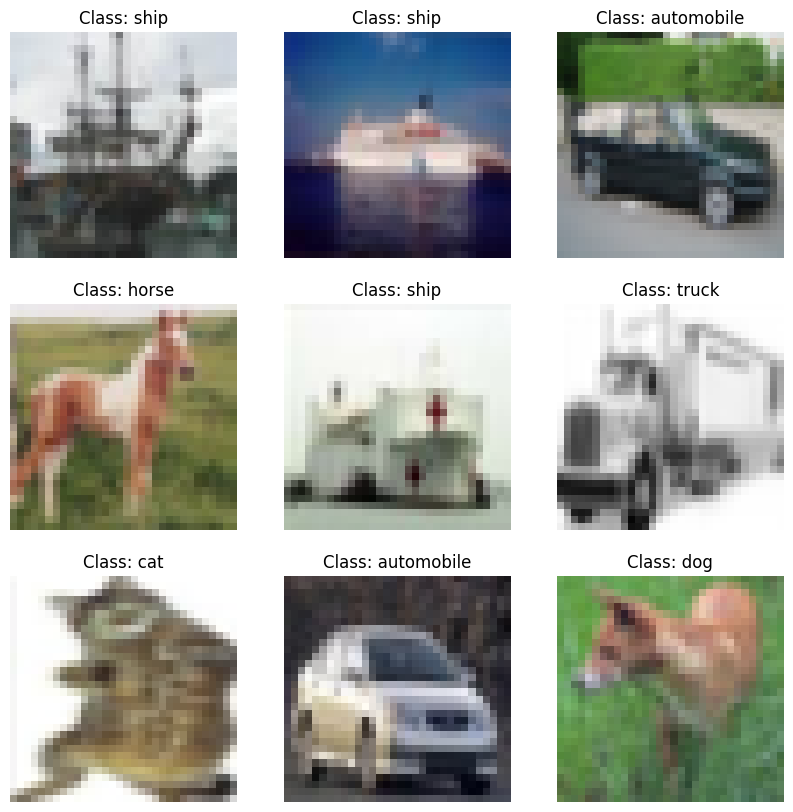

In [13]:
plot_9_random_images(cifar10_train)

### B.1.2) Data Augmentation

Data augmentation is a technique to artificially increase the size of the training set by applying transformations to the input data. This can help the model generalize better to unseen data.

We will use the `torchvision.transforms` module to apply some transformations to the input data.

In [14]:
data_augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Horizontal flip with probability 0.5
    transforms.RandomRotation(10),      # Rotate the image by a random angle between -10 and 10 degrees
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0))  # Take a random crop of the original image with an area between 80% to 100% of the original image
])

### B.1.3) `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`

Now that we have the data as a list and the data augmentation transformation, we can use the `torch.utils.data.Dataset` class to create a PyTorch dataset. Look [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for a deeper tutorial on how to use `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`.

A `Dataset` is a Python class that represents a dataset. It should implement three methods:

- `__init__`: where you specify how or where to load the dataset;
- `__getitem__`: where you specify how to get the $i$-th sample of the dataset;
- `__len__`: where you specify how to get the length of the dataset.


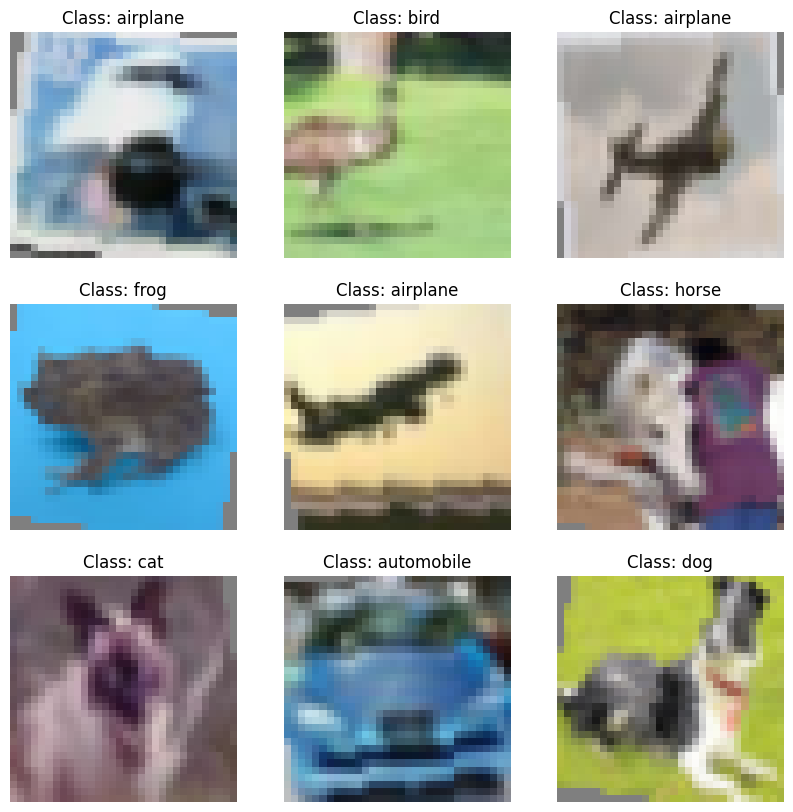

In [15]:
# Create new Dataset objects to apply data augmentation
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.data[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.data)

cifar10_train_aug = TransformedDataset(cifar10_train, data_augmentation_transform) # The data augmentation is only applied whenever a sample is requested

# This is done only to show the usage of datasets, this transforms can be applied directly while downloading the CIFAR dataset
# Plot 9 random images from the unbalanced dataset
plot_9_random_images(cifar10_train_aug)

`Dataset` are used to define how to load and preprocess the data, while `DataLoader` are used to actually load the data in batches.

In [16]:
BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(cifar10_train_aug, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=BATCH_SIZE, shuffle=False)

# The dataloader can be used as an iterator
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([64, 3, 32, 32]) torch.Size([64])


## B.2) Define the CNN

As before, to build a CNN in PyTorch, we define a class that inherits from `torch.nn.Module`. This class has the same two main methods:

- `__init__` method, where you define the layers of the network;
- `forward` method, where you define the forward pass of the network.


### Exercise:
Compute the number of parameters in every layer and the output shape in every step of the forward pass, then fill in the in_features in fc1

In [24]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Out channels are the number of filters that we have
        # The kernel size is 3x3, the input channels are 3 (RGB), the output channels are 16 (number of filters)
        # Padding is 'same' means that the output size is the same as the input size
        # stride is 1 by default, how much we move the kernel

        # The + part is the bias term, which is added to the output of the convolution for each filter
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding='same')  # Parameters = 3*3*3*16 + 16 = 448
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding="same") # Parameters = 3*3*16*32 + 32 = 4640
        # Padding is 'valid' means that the output size is smaller than the input size
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="valid") # Parameters = 3*3*32*64 + 64 = 18496

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Parameters = 0

        # 576 computed in the forward function by looking at the size of the last conv layer
        self.fc1 = nn.Linear(in_features=576, out_features=128) # Parameters = 576 * 128 + 128 = 73728
        self.fc2 = nn.Linear(in_features=128, out_features=10) # Parameters = 128 * 10 + 10 = 1290

        self.activation = nn.ReLU() # Parameters =
        self.softmax = nn.Softmax(dim=1) # Parameters =

    def forward(self, x):   #Input shape: (batch_size, 3, 32, 32)
        # batch_size, output_depth, output_height, output_width
        # Output of the pool layer divides by 2 the size of the image
        x = self.activation(self.conv1(x))  #Output shape = (batch_size, 16, 32, 32)
        x = self.pool(x)                    #Output shape = (batch_size, 16, 16, 16)
        x = self.activation(self.conv2(x))  #Output shape = (batch_size, 32, 16, 16)
        x = self.pool(x)                    #Output shape = (batch_size, 32, 8, 8)
        x = self.activation(self.conv3(x))  #Output shape = (batch_size, 64, 6, 6)
        x = self.pool(x)                    #Output shape = (batch_size, 64, 3, 3)

        # Final layer is of size 64*3*3 = 576
        x = torch.flatten(x, 1)                     #Output shape = (batch_size, 64*3*3)

        x = self.activation(self.fc1(x))    #Output shape = (batch_size, 128)

        x = self.fc2(x)                     #Output shape = (batch_size, 10)

        return x # We don't apply the softmax here because it is included in the torch implementation of the cross entropy loss function

In [44]:
summary(CNN(), (3, 32, 32)) # Print the summary of the model

# There are way more params in the fully connected layers than in the convolutional layers
# this is because the fully connected network is much more inefficient

# Reduce the number of dimensions, otherwise you will have a really big image and it
# will crash / really heavy to train


#### Most of the time you will fail a task because of the data, not because of the model
# be sure to really understand the data that you are working with
# don't spend too much time playing with the hyperparameters of the model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 6, 6]          18,496
              ReLU-8             [-1, 64, 6, 6]               0
         MaxPool2d-9             [-1, 64, 3, 3]               0
           Linear-10                  [-1, 128]          73,856
             ReLU-11                  [-1, 128]               0
           Linear-12                   [-1, 10]           1,290
Total params: 98,730
Trainable params: 98,730
Non-trainable params: 0
---------------------------------

In [28]:
criterion = torch.nn.CrossEntropyLoss().to(device)

## B.4) Train the CNN

In [29]:
def train(model, criterion, optimizer, train_loader, val_loader, n_epochs, eval_freq, device):
    training_losses = []
    validation_losses = []

    for epoch in range(n_epochs):
        model.train()                       # Set the model to training mode, this is important for some layers (e.g. dropout)

        for x, y in train_loader:           # Access the training data
            training_losses_epoch = []
            optimizer.zero_grad()           # Zero the gradients
            x, y = x.to(device), y.to(device)
            y_pred = model(x)               # Forward pass

            loss = criterion(y_pred, y)
            loss.backward()                 # Compute the gradients
            optimizer.step()                # Update the weights

            training_losses_epoch.append(loss.item())
        training_losses.append(np.mean(training_losses_epoch))

        # Validation
        model.eval()                        # Set the model to evaluation mode
        if epoch % eval_freq == 0:
            with torch.no_grad():            # No need to compute the gradients
                val_loss = 0
                for x, y in val_loader:
                    x, y = x.to(device), y.to(device)
                    y_val_pred = model(x)
                    val_loss += criterion(y_val_pred, y)
                validation_losses.append(val_loss.item() / len(val_loader))

            print(f'Epoch {epoch}, Train Loss {training_losses[-1]:.4f}')
            print(f'Validation Loss {validation_losses[-1]:.4f}')
            print('')

    return training_losses, validation_losses

In [30]:
# Reinitalize the model
model = CNN().to(device)

# Training
optimizer = optim.Adam(model.parameters(), lr=0.001)

eval_freq = 1
n_epochs = 3

training_losses, validation_losses = train(model, criterion, optimizer, train_loader, val_loader, n_epochs, eval_freq, device)

Epoch 0, Train Loss 1.3814
Validation Loss 1.3597

Epoch 1, Train Loss 0.7963
Validation Loss 1.1797

Epoch 2, Train Loss 1.5239
Validation Loss 1.0399



In [31]:
# Test the accuracy on the test set
test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=BATCH_SIZE, shuffle=False)

correct = 0
total = 0
model.to(device)

model.eval()

true_labels = []
predicted_labels = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        _, predicted = torch.max(y_pred, dim=1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
        true_labels.extend(y.detach().cpu().numpy())
        predicted_labels.extend(predicted.detach().cpu().numpy())

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')



Accuracy of the network on the 10000 test images: 61.86%


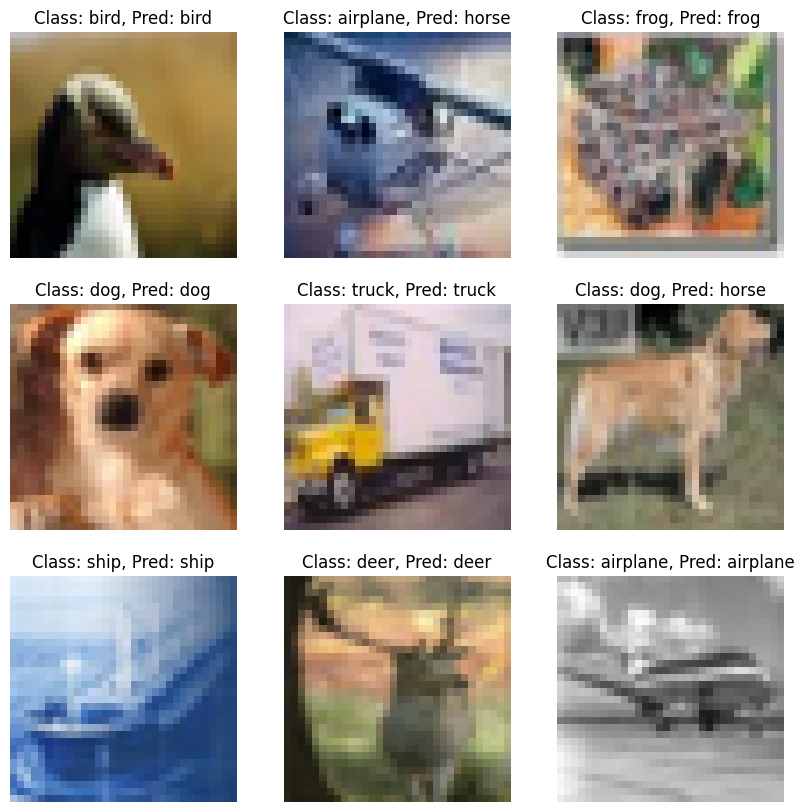

In [32]:
plot_9_random_images(cifar10_test, with_predictions=True, model=model.cpu())

### Exercise - Home: Confusion matrix
Plot the confusion matrix of the predictions

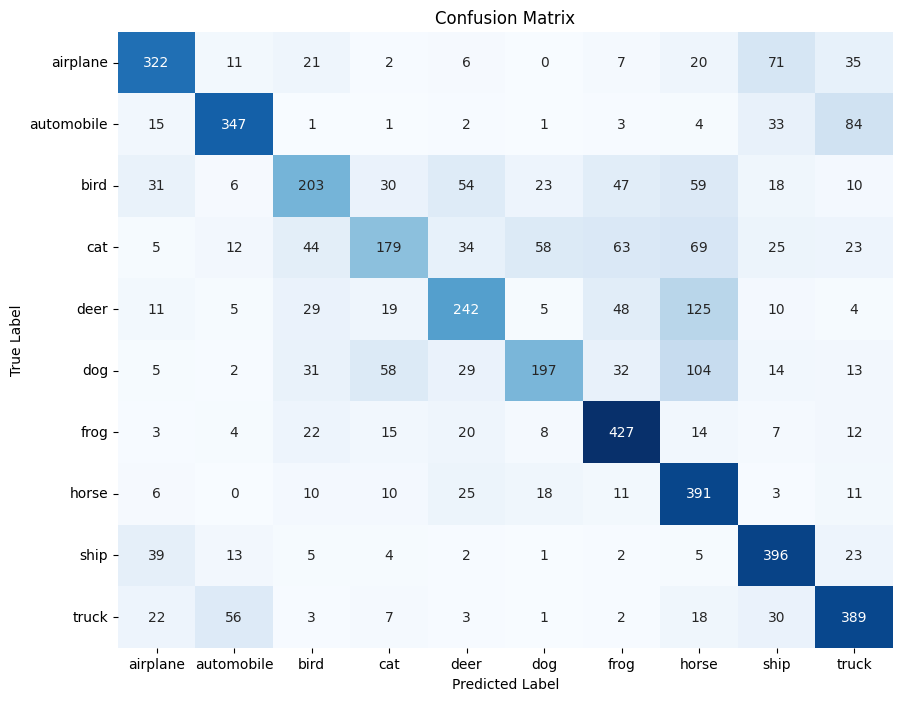

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cm_df = pd.DataFrame(cm, index=class_label_map, columns=class_label_map)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Ideally we want to have a diagonal matrix, which means that the model is predicting the correct class
# In reality we have some misclassifications

### Exercise - Home: Unbalanced dataset
Now we make the dataset unbalanced by removing some samples from the classes "frog" and "truck".

An unbalanced dataset is a dataset where the number of samples in each class is not equal (usually very different). This is a common problem in classification tasks, and can lead to poor performance of the classifier.

How can we deal with the new dataset?

In [38]:
# Remove some samples from the "cat" and "truck" classes in the training set with probability P
P = 0.2
unbalanced_train_data = [(x, y) for x, y in cifar10_train if y not in [3, 9]]
unbalanced_train_data += [(x, y) for x, y in cifar10_train if y in [3, 9] and torch.rand(1) < P]

In [39]:
unbalanced_trainset = TransformedDataset(unbalanced_train_data, data_augmentation_transform) # The data augmentation is only applied whenever a sample is requested


Some tips:
There are various techniques to deal with unbalanced datasets, such as:

- **Resampling**: This involves either oversampling the minority class or undersampling the majority class to balance the dataset.
- **Data Augmentation**: This involves artificially increasing the size of the training set by applying transformations to the input data.
- **Weighted Loss**: This involves assigning different weights to the classes in the loss function, so that the model pays more attention to the minority class.

The **Weighted Loss** technique consists in __re-weighting__ the loss function, so that the error on rare samples will count more than the error on common samples:

$$
L_{\textrm{reweighted}}(y, f(X; W)) =
\begin{cases}
\lambda_0 L(y, f(X; W))\textrm{, if } y=0 \\
\lambda_1 L(y, f(X; W))\textrm{, if } y=1
\end{cases}
$$

Ideally, $\lambda_0$ and $\lambda_1$ should represent how rare the respective classes are in the dataset.
A common way of computing the two values automatically is as:

$$
\lambda_i = \frac{\textrm{\# samples in dataset}}{\textrm{\# classes}\cdot\textrm{\# samples of class } i}
$$


# C) Food Classification Problem
A real world problem to solve with CNN and transfer learning

## C.1) Load and preprocess the data

We will use a Food Classification Dataset.
The original dataset contains 24K images of 35 types of indian and western food.
I simplified the dataset keeping 14 classes with respectively 640 train images, 160 validation and 200 test
Images are RGB 512x512.

Put to true if you are using colab

In [40]:
use_colab = False

If you are using colab, to load the dataset you should open the zip on GDrive and connect using this API.
Do not put the folder into "shared with me" but is a subfolder of you main GDrive directory

In [41]:
transformations = transforms.Compose([transforms.Resize([256,256]),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

In [ ]:
if use_colab:
    from google.colab import drive
    drive.mount('/gdrive')
    %cd /gdrive/My\ Drive/PYTORCH/deep_learning_usi/session_04
    
    trainset = torchvision.datasets.ImageFolder(root='dataset/train', transform=transformations)

    valset = torchvision.datasets.ImageFolder(root='dataset/val', transform=transformations)

    testset = torchvision.datasets.ImageFolder(root='dataset/test',transform=transformations)


In [42]:
if not use_colab:
    #change here to the path to your dataset
    import os
    folder = "data/"
    trainset = torchvision.datasets.ImageFolder(root=os.path.join(folder,'dataset/train'), transform=transformations)

    valset = torchvision.datasets.ImageFolder(root=os.path.join(folder,'dataset/val'), transform=transformations)

    testset = torchvision.datasets.ImageFolder(root=os.path.join(folder,'dataset/test'),transform=transformations)

FileNotFoundError: [Errno 2] No such file or directory: 'data/dataset/train'

In [ ]:
class_label_map = trainset.classes

In [ ]:
plot_9_random_images(trainset, with_predictions=False)

In [ ]:
trainset_aug = TransformedDataset(trainset, data_augmentation_transform) # The data augmentation is only applied whenever a sample is requested


In [ ]:
BATCH_SIZE = 128

train_loader = torch.utils.data.DataLoader(trainset_aug, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False)

## C.2) Use VGG16

Download, inspect and customize a pretrained network to perform transfer learning

In [ ]:
from torchvision.models import vgg16, VGG16_Weights

In [ ]:
vgg = vgg16(weights = VGG16_Weights.IMAGENET1K_V1)

In [ ]:
#Freeze
for param in vgg.parameters():
    param.requires_grad = False

In [ ]:
class VGGClassifier(nn.Module):
    def __init__(self, vgg_backbone, num_classes):
        super().__init__()
        self.features = vgg_backbone.features
        #self.avgpool = vgg_backbone.avgpool  # This is the original avgpool of VGG16, that is reducing the feature map in output to 512x7x7 regardless the original size of the image,
                                                # however this type of adaptive pool with input sizes not divisible by output sizes are not yet available for MPS (Mac architecture)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1)) # To deal with it, let's use another avgpool reducing the feature map to 512x1x1, this way we can use any input size also on Mac

        self.fc = nn.Linear(512, num_classes)
    def forward(self, x):
        x = self.features(x) #[N, 512, 1, 1]
        x = self.avgpool(x)   # [N, 512, 7, 7] for standard VGG16
        x = torch.flatten(x, 1) #[N, 512*7*7]
        x = self.fc(x) #[N, 14]
        return x

In [ ]:
vgg_classifier = VGGClassifier(vgg, 14).to(device)


In [ ]:
vgg_save_folder = "models/vgg/"
os.makedirs(vgg_save_folder, exist_ok = True)
vgg_save_file = os.path.join(vgg_save_folder,"model.pt")
vgg_save_log = os.path.join(vgg_save_folder,"log.json")

In [ ]:
do_train = True

In [ ]:
# Training
import json
if do_train:
    optimizer = optim.Adam(vgg_classifier.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    eval_freq = 1
    n_epochs = 3

    training_losses, validation_losses = train(vgg_classifier, criterion, optimizer, train_loader, val_loader, n_epochs, eval_freq, device)
    to_save_json = {"train_losses":training_losses,
                "test_losses":validation_losses}
    with open(vgg_save_log, 'w') as f:
      json.dump(to_save_json, f)

In [ ]:
if do_train:
    torch.save(vgg_classifier.state_dict(), vgg_save_file)

In [ ]:
vgg_classifier.load_state_dict(torch.load(vgg_save_file, map_location=torch.device('cpu')))
with open(vgg_save_log, "r") as f:
    vgg_log = json.load(f)

In [ ]:
vgg_classifier.to(device)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(vgg_log['train_losses'], label='Train Loss')
plt.plot(vgg_log['test_losses'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

correct = 0
total = 0

vgg_classifier.eval()

true_labels = []
predicted_labels = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_pred = vgg_classifier(x)
        _, predicted = torch.max(y_pred, dim=1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
        true_labels.extend(y.detach().cpu().numpy())
        predicted_labels.extend(predicted.detach().cpu().numpy())

print(f'Accuracy of the network on the test images: {100 * correct / total}%')


In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)
df_cm = pd.DataFrame(cm, index=class_label_map, columns=class_label_map)
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Exercise - Home: Improve my result
The network that I proposed is a first attempt by me.

There are for sure margins for improvement (during the lectures you have seen several tools to understand when a model performs better than one other)

Remember to assess and improve your network using the validation set, and just use the test set at the end.

Some tips:
-  Always check if the dataset is balanced before proceeding.
-  Perform hyperapameter tuning (learning rate, optimizer, ...).
-  Customize the small network appended after VGG.
-  Add Early Stopping to select an optimal number of epochs.
-  Try new Augmentations.
-  <b>Be creative! </b>.
